## Access the annotation file 

In [10]:
json_file='/content/drive/MyDrive/Colab Notebooks/DL_project_updated_68_json.json'

In [11]:
import random
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
# Set random seeds for reproducibility 
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Make a dataframe of the annotated json and so necessary preprocessing 

In [13]:
annotation_df= pd.read_json(json_file)
annotation_df = annotation_df.transpose().reset_index()[['filename','regions']]
shape_attributes = []
for row in range(annotation_df.shape[0]):
    data = annotation_df['regions'][row][0]['shape_attributes']
    shape_attributes.append(data)
region_attributes = []
for row in range(annotation_df.shape[0]):
    data = annotation_df['regions'][row][0]['region_attributes']
    region_attributes.append(data)  
shape_attributes_df = pd.DataFrame(shape_attributes)
shape_attributes_df= shape_attributes_df.rename(columns= {"name": "shape_name"})    

region_attributes_df = pd.DataFrame(region_attributes)
region_attributes_df= region_attributes_df.rename(columns= {"name": "object_name"})

annotation_df = pd.concat([annotation_df,shape_attributes_df, region_attributes_df],1)
annotation_df

<ipython-input-13-36a455c192cc>:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  annotation_df = pd.concat([annotation_df,shape_attributes_df, region_attributes_df],1)


,filename,regions,shape_name,all_points_x,all_points_y,object_name,type,image_quality
0,IMG_0062.png,"[{'shape_attributes': {'name': 'polyline', 'al...",polyline,"[616, 664, 761, 869, 911, 0, 6, 622]","[3169, 2499, 1515, 519, 12, 6, 3175, 3169]",building,building,"{'good': True, 'frontal': True}"
1,IMG_0068.png,"[{'shape_attributes': {'name': 'polyline', 'al...",polyline,"[12, 0, 416, 489, 700, 863, 1237, 1328, 1545, ...","[2547, 2873, 2879, 2873, 2855, 2801, 2813, 280...",building,building,"{'good': True, 'good_illumination': True, 'sid..."
2,IMG_0079.png,"[{'shape_attributes': {'name': 'polyline', 'al...",polyline,"[6, 60, 97, 139, 199, 181, 217, 229, 0, 0, 205...","[2789, 2710, 2270, 1624, 1086, 899, 911, 561, ...",Building,building,"{'good': True, 'good_illumination': True, 'sid..."
3,IMG_0081.png,"[{'shape_attributes': {'name': 'polyline', 'al...",polyline,"[12, 561, 616, 6, 12]","[2559, 2571, 2583, 2529, 2559]",Road\n,road,"{'good': True, 'side': True, 'far away': True}"
4,IMG_0083.png,"[{'shape_attributes': {'name': 'polyline', 'al...",polyline,"[6, 338, 483, 984, 2276, 1986, 1859, 1781, 203...","[2451, 2432, 2445, 2390, 2282, 2215, 2185, 218...",Road\n,road,"{'good': True, 'frontal': True, 'good_illumina..."
...,...,...,...,...,...,...,...,...
63,IMG_0122.png,"[{'shape_attributes': {'name': 'polygon', 'all...",polygon,"[16, 1062, 1070, 1264, 1264, 1835, 3010, 3018,...","[1054, 1368, 1400, 1457, 1505, 1658, 1288, 269...",Building,building,"{'good': True, 'frontal': True, 'good_illumina..."
64,IMG_0129.png,"[{'shape_attributes': {'name': 'polygon', 'all...",polygon,"[16, 1384, 3002, 3010, 1803, 1829, 1527, 930, ...","[8, 0, 1360, 2656, 2624, 3591, 3857, 4020, 401...",Building,building,"{'good': True, 'good_illumination': True, 'sid..."
65,IMG_0130.png,"[{'shape_attributes': {'name': 'polygon', 'all...",polygon,"[1135, 1433, 2052, 2068, 2036, 1883, 1690, 146...","[1690, 1505, 1714, 2302, 2463, 2503, 2503, 250...",Building,building,"{'good': True, 'frontal': True, 'good_illumina..."
66,IMG_0135.png,"[{'shape_attributes': {'name': 'polygon', 'all...",polygon,"[16, 684, 1891, 3010, 3002, 2712, 2640, 2511, ...","[1497, 137, 821, 1465, 3694, 3750, 3750, 3766,...",Building,building,"{'good': True, 'good_illumination': True, 'sid..."


In [6]:
# Define image directory and the directory for the Masked Images
img_dir = '/content/drive/MyDrive/Colab Notebooks/Training_images_68'

### This is the custom dataset class for our mini network.

In [7]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from ast import literal_eval
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations_df, transform=None, save_dir=None):
        self.img_dir = img_dir
        self.annotations_df = annotations_df
        self.transform = transform
        self.save_dir = save_dir
        print(f"save_dir: {save_dir}")
        if self.save_dir and not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        # load image
        img_name = self.annotations_df.iloc[idx]["filename"]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)

        # load annotation
        regions = self.annotations_df.iloc[idx]["regions"]

        # create multi-channel mask from annotation
        mask = create_mask_from_annotation(regions, img.shape[:2])

        # Convert NumPy arrays to PIL format
        img = Image.fromarray(img)
        mask = Image.fromarray(mask)
        #To apply same transformation to image and it's corresponding mask
        random.seed(42)
        torch.manual_seed(42)
        # Apply transform if specified
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        
        img = np.array(img)
        mask = np.array(mask)
        
        # save masked image to disk
        if self.save_dir:
            save_path = os.path.join(self.save_dir, f"{img_name[:-4]}_masked.jpg")
            print(f"Saving masked image to {save_path}")
            masked_img = cv2.bitwise_and(img, mask)
            masked_img = masked_img.transpose((1, 2, 0))  # convert to (height, width, channels)
            if masked_img.shape[2] > 4:
                masked_img = masked_img[:, :, :3]  # convert to RGB
            print(f"Masked image shape: {masked_img.shape}")
            cv2.imwrite(save_path, masked_img)
            print("Saved masked image")
        
        # convert to tensor and return
        img = img.transpose((0, 1, 2))
        mask = mask.transpose((0, 1, 2))

        return img, mask




def create_mask_from_annotation(regions, image_size):
    """
    Create a multi-channel binary mask from annotation regions.
    
    Args:
        regions: annotation regions
        image_size: size of the image
        
    Returns:
        A multi-channel binary mask with one channel for each class
    """
    mask = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    
    # iterate over each region
    for region in regions:
        # get shape attributes
        shape_attributes = region['shape_attributes']
        all_points_x = shape_attributes['all_points_x']
        all_points_y = shape_attributes['all_points_y']
        
        # get region attributes
        region_attributes = region['region_attributes']
        class_name = region_attributes['type']
        
        # set mask values based on class
        if class_name == 'road':
            color = (255, 0, 0)
        elif class_name == 'tree':
            color = (0, 255, 0)
        elif class_name == 'building':
            color = (0, 0, 255)
        else: # set all other pixels to black
            color = (0, 0, 0)

        
        # create mask for region
        polygon = list(zip(all_points_x, all_points_y))
        polygon = np.array(polygon, np.int32)
        cv2.fillPoly(mask, [polygon], color)
    
    return mask

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])


from torch.utils.data import DataLoader


# Create the full dataset
dataset = CustomDataset(img_dir, annotation_df, transform=train_transform, save_dir=None)

num_data = len(dataset)
train_size = int(0.8 * num_data)
val_size = int(0.1 * num_data)
test_size = num_data - train_size - val_size



train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

# Compute mean and standard deviation for normalization
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
mean = 0.
std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(train_loader.dataset)
std /= len(train_loader.dataset)

print(f"Mean: {mean}")
print(f"Std: {std}")

# Define transform with normalization
normalize = transforms.Normalize(mean=mean.tolist(), std=std.tolist())

train_dataset.transform = transforms.Compose([
    normalize
])

val_dataset.transform = transforms.Compose([
    val_transform,
    normalize
])

test_dataset.transform = transforms.Compose([
    test_transform,
    normalize
])



# Create dataloaders for each subset
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


save_dir: None
Mean: tensor([0.5047, 0.5156, 0.5147])
Std: tensor([0.3204, 0.2952, 0.2829])


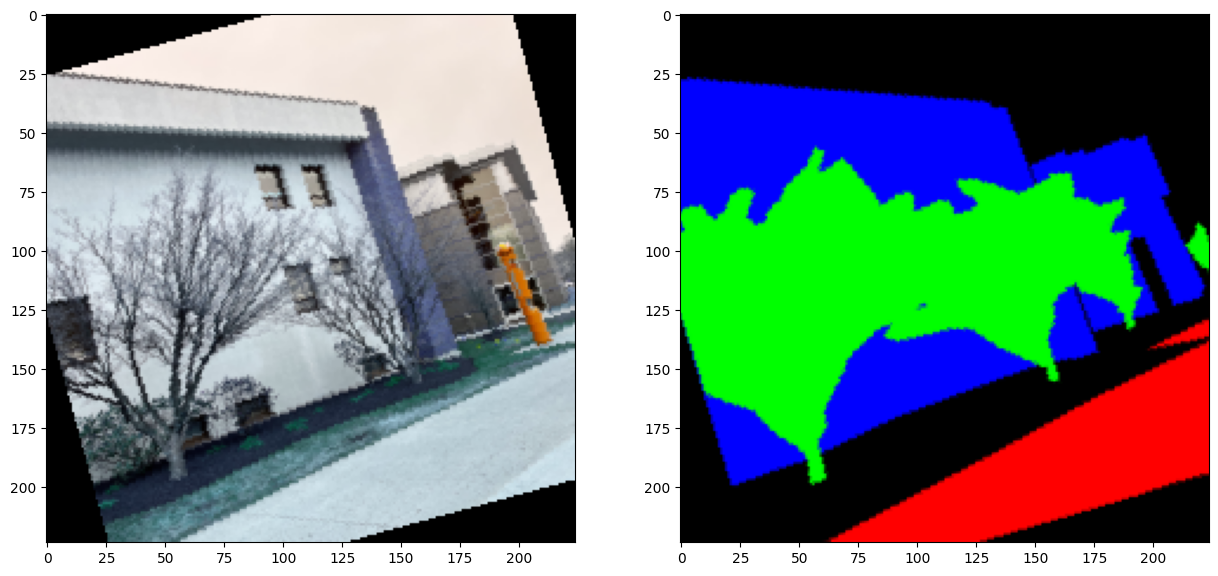

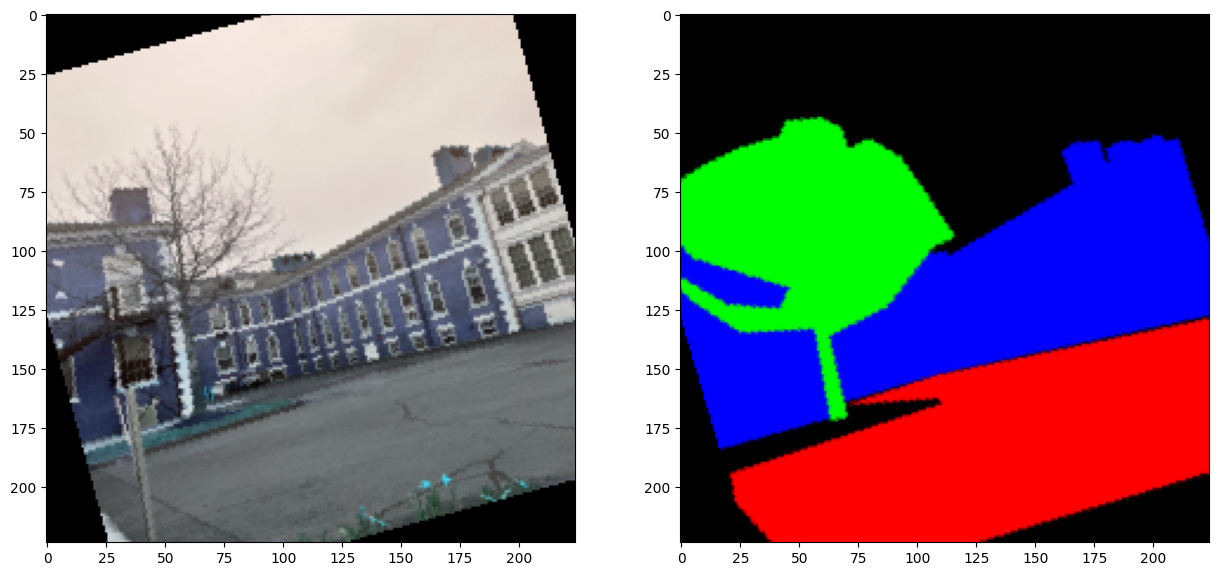

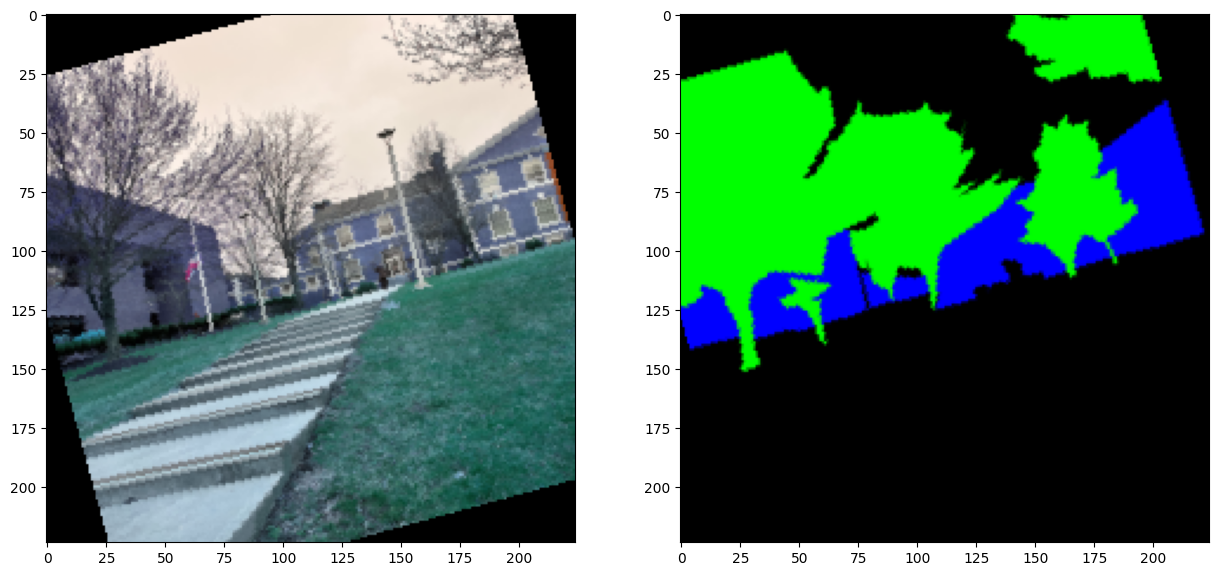

In [8]:
import matplotlib.pyplot as plt
import torch.nn.functional as F



# Define a function to plot the first sample of each minibatch
def plot_samples(data_loader):
    
  images, masks = next(iter(data_loader))
  

  # plot image and mask side by side
  fig, ax = plt.subplots(1, 2, figsize=(15, 10))
  ax[0].imshow(images[0].permute(1,2,0))
  ax[1].imshow(masks[0].permute(1,2,0))
  plt.show()

# Plot the first sample of each minibatch in the training set
plot_samples(train_loader)

# Plot the first sample of each minibatch in the validation set
plot_samples(val_loader)

# Plot the first sample of each minibatch in the test set
plot_samples(test_loader)

In [9]:
! pip install ray 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 37.9 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, criterion, num_epochs, scheduler=None, patience=10):
    # set the model to train mode
    model.train()

    # initialize lists to store losses and accuracies for each epoch
    train_losses = []
    valid_losses = []
    test_losses = []
    train_accs = []
    valid_accs = []
    test_accs = []

    # initialize variables to keep track of best model
    best_model = None
    best_acc = 0.0
    best_loss = float('inf')
    early_stop_counter = 0

    # loop over the specified number of epochs
    for epoch in tqdm(range(num_epochs), desc=f"Training Epochs ({num_epochs})", position=0, leave=True):
        # train the model
        model.train()
        num_classes=3
        # Initialize epoch loss, accuracy, and IoU
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        epoch_iou = [0.0] * num_classes
        tp = [0] * num_classes
        fp = [0] * num_classes
        fn = [0] * num_classes
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_iou = [0.0] * num_classes
        tp_val = [0] * num_classes
        fp_val = [0] * num_classes
        fn_val = [0] * num_classes        
        early_stop_count = 0

        # Loop over the training data
        for batch_idx, (data, target) in enumerate(train_loader):
            # Move the data and target tensors to the device (GPU if available)
            data, target = data.to(device), target.to(device)

            # Zero out the gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data.float())
            predicted = torch.argmax(output, dim=1)

            # Convert target tensor from one-hot encoding to class indices
            target = torch.argmax(target, dim=1)

            # Compute the loss
            loss = criterion(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update epoch loss, accuracy, and IoU
            epoch_loss += loss.item() * data.size(0)
            epoch_total += target.view(-1).size(0)
            epoch_correct += predicted.view(-1).eq(target.view(-1)).sum().item()
            for c in range(num_classes):
                tp[c] += ((predicted == c) & (target == c)).sum().item()
                fp[c] += ((predicted == c) & (target != c)).sum().item()
                fn[c] += ((predicted != c) & (target == c)).sum().item()
            for c in range(num_classes):
                if tp[c] + fp[c] + fn[c] == 0:
                    epoch_iou[c] = 0.0
                else:
                    epoch_iou[c] = tp[c] / (tp[c] + fp[c] + fn[c])

        # Compute epoch loss, accuracy, and mean IoU
        epoch_loss /= len(train_loader.dataset)
        epoch_acc = 100. * epoch_correct / epoch_total
        mean_iou = sum(epoch_iou) / num_classes
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total=0
        with torch.no_grad():
          for data, target in val_loader:
              data, target = data.to(device), target.to(device)

              # forward pass
              output = model(data.float())
              predicted = torch.argmax(output, dim=1)
              # convert target tensor from one-hot encoding to class indices
              target = torch.argmax(target, dim=1)

              # compute the loss
              val_loss += criterion(output, target).item() * data.size(0)

              # update accuracy
              val_total += target.view(-1).size(0)
              val_correct += predicted.view(-1).eq(target.view(-1)).sum().item()
              for c in range(num_classes):
                tp_val[c] += ((predicted == c) & (target == c)).sum().item()
                fp_val[c] += ((predicted == c) & (target != c)).sum().item()
                fn_val[c] += ((predicted != c) & (target == c)).sum().item()
              for c in range(num_classes):
                if tp_val[c] + fp_val[c] + fn_val[c] == 0:
                    val_iou[c] = 0.0
                else:
                    val_iou[c] = tp_val[c] / (tp_val[c] + fp_val[c] + fn_val[c])

              # adjust the learning rate
              if scheduler is not None:
                    scheduler.step()
              
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100* val_correct / val_total
        Valid_mean_iou = sum(val_iou) / num_classes
        # save the model with best accuracy and lower loss
        if val_accuracy > best_acc or (val_accuracy == best_acc and val_loss < best_loss):
            best_acc = val_accuracy
            best_loss = val_loss
            best_model = model.state_dict()
            early_stop_counter = 0  # reset counter if we find a new best model
        else:
            early_stop_counter += 1  # increment counter if we didn't find a new best model
            if early_stop_counter == patience:
                print(f'\nEarly stopping after {epoch+1} epochs.')
                break

        # print loss, accuracy, and IoU for training dataset
        print(f'\nEpoch {epoch+1} | Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.2f}% ') #Train IoU: {epoch_iou}')
        #print(f'\nEpoch {epoch+1} | valid Loss: {val_loss:.4f}, Valid Accuracy: {val_accuracy:.2f}% ') #Train IoU: {val_iou}')


        # append losses and accuracies to respective lists
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        valid_losses.append(val_loss)
        valid_accs.append(val_accuracy)
    # save the best model to file
    torch.save(best_model, '/content/drive/MyDrive/Colab Notebooks/Mini_network/best_model.pt')
    print('Best Model Saved in the location /content/drive/MyDrive/Colab Notebooks/Mini_network as best_model.pt')
    

    return train_losses, train_accs, valid_losses, valid_accs


In [15]:
def test_accuracy(model, device="cpu"):
    # set the model to eval mode
    model.eval()
    
    # initialize loss and accuracy
    loss = 0
    correct = 0
    total = 0
    criterion= nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for data, target in test_loader:
            # move the data and target tensors to the device (GPU if available)
            data, target = data.to(device), target.to(device)

            # forward pass
            output = model(data.float())
            predicted = torch.argmax(output, dim=1)
            # convert target tensor from one-hot encoding to class indices
            target = torch.argmax(target, dim=1)

            # compute the loss
            loss += criterion(output, target).item() * data.size(0)

            # update accuracy
            total += target.view(-1).size(0)
            correct += predicted.view(-1).eq(target.view(-1)).sum().item()

    loss /= len(test_loader.dataset)
    acc = 100. * correct / total

    return acc

In [ ]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 37.0 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [18]:
import torch.nn.init as init

class MiniNetversion_DenseASPP(nn.Module):
    def __init__(self, n_class=3):
        super(MiniNetversion_DenseASPP, self).__init__()

        # First convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Initialize weights with Kaiming initialization and biases with zeros
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

        # Dense block1
        self.block1 = nn.Sequential(
            nn.Conv2d(96, 12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True)
        )

        # Transition1
        self.trans1 = nn.Sequential(
            nn.Conv2d(108, 54, kernel_size=1),
            nn.BatchNorm2d(54),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear')
        )

        # Final batch norm
        self.final_bn = nn.BatchNorm2d(54)

        # ASPP_3
        self.ASPP_3 = nn.Sequential(
            nn.Conv2d(54, 512, kernel_size=3, dilation=3, padding=3),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        # ASPP_6
        self.ASPP_6 = nn.Sequential(
            nn.Conv2d(182, 512, kernel_size=3, dilation=6, padding=6),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.1),
            nn.Conv2d(512, 128, kernel_size=1),
            nn.ReLU(inplace=True)
        )

        # Final classification layer
        self.classification = nn.Sequential(
            nn.Dropout2d(p=0.1),
            nn.Conv2d(in_channels=310, out_channels=n_class, kernel_size=1),
            nn.Upsample(scale_factor=2, mode='bilinear')
        )

    def forward(self, x):
        f0 = self.features(x)
        b1 = self.block1(f0)
        f1 = torch.cat((f0, b1), dim=1)
        t1 = self.trans1(f1)
        t1 = self.final_bn(t1) # Add final batch norm
        a3 = self.ASPP_3(t1)
        f2 = torch.cat((a3, t1), dim=1)
        a6 = self.ASPP_6(f2)
        f3 = torch.cat((a6, f2), dim=1)
        output = self.classification(f3)

        return output

if __name__ == "__main__":
    model_3 = MiniNetversion_DenseASPP(3)
   


In [19]:
model_3

MiniNetversion_DenseASPP(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): Conv2d(96, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trans1): Sequential(
    (0): Conv2d(108, 54, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Upsample(scale_factor=2.0, mode='bilinear')
  )
  (final_bn): BatchNorm2d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ASPP_3): Sequential(
    (0): Conv2d(54, 512, kernel_size=(3, 3), stride=(1, 1), p

## Let's overfit the model by training on only one sample. 

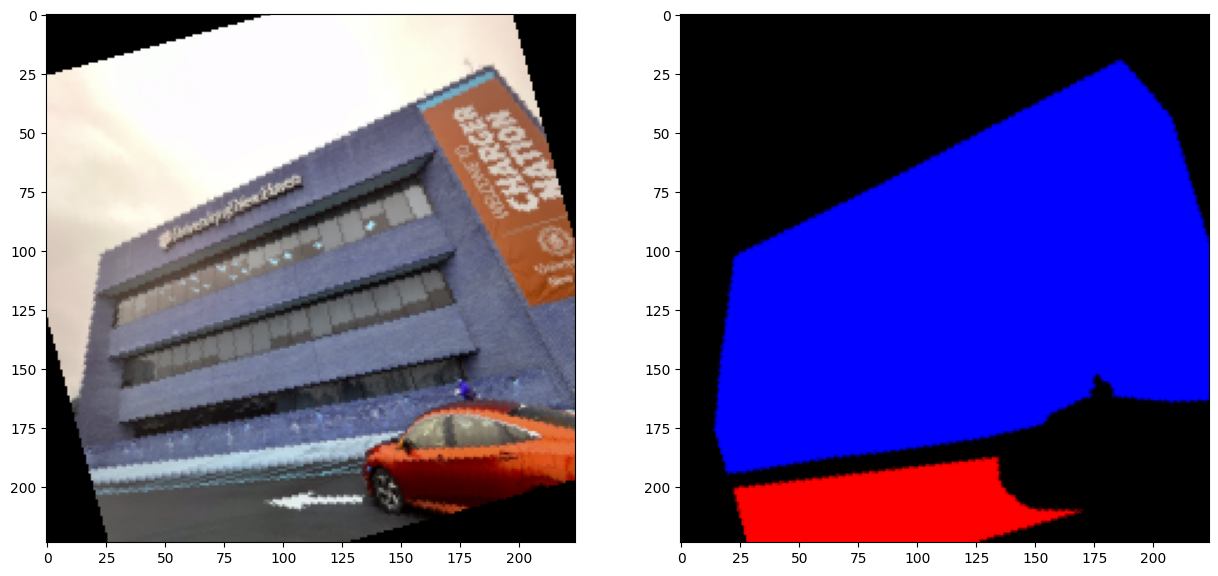

In [14]:
# Set random seeds for reproducibility

from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from torch.utils.data import Subset
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# create a new dataset with only one or two samples
one_sample_dataset = Subset(train_dataset, [4]) # replace 0 with the index of the sample you want to use

# create a data loader with batch size 1
one_sample_loader = DataLoader(one_sample_dataset, batch_size=1, shuffle=True)

plot_samples(one_sample_loader)


In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set the number of epochs to a large number



# Define your model, criterion, optimizer, scheduler, and other parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.001, momentum=0.4,  weight_decay=0.0002)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 50
train_losses_3, train_accs_3, valid_losses_3, valid_accs_3 = train(model_3, device, one_sample_loader,optimizer, criterion, num_epochs, scheduler=scheduler)

Training Epochs (50):   2%|▏         | 1/50 [00:12<10:16, 12.58s/it]


Epoch 1 | Train Loss: 0.1939, Train Accuracy: 97.08%, valid Loss: 1.0297, Valid Accuracy: 53.76% 


Training Epochs (50):   4%|▍         | 2/50 [00:23<09:14, 11.56s/it]


Epoch 2 | Train Loss: 0.1935, Train Accuracy: 97.10%, valid Loss: 1.0295, Valid Accuracy: 53.78% 


Training Epochs (50):   6%|▌         | 3/50 [00:35<09:20, 11.93s/it]


Epoch 3 | Train Loss: 0.1929, Train Accuracy: 97.13%, valid Loss: 1.0292, Valid Accuracy: 53.78% 


Training Epochs (50):   8%|▊         | 4/50 [00:47<09:05, 11.85s/it]


Epoch 4 | Train Loss: 0.1923, Train Accuracy: 97.16%, valid Loss: 1.0295, Valid Accuracy: 53.78% 


Training Epochs (50):  10%|█         | 5/50 [00:59<08:51, 11.82s/it]


Epoch 5 | Train Loss: 0.1916, Train Accuracy: 97.18%, valid Loss: 1.0290, Valid Accuracy: 53.79% 


Training Epochs (50):  12%|█▏        | 6/50 [01:10<08:31, 11.61s/it]


Epoch 6 | Train Loss: 0.1909, Train Accuracy: 97.22%, valid Loss: 1.0285, Valid Accuracy: 53.80% 


Training Epochs (50):  14%|█▍        | 7/50 [01:21<08:05, 11.30s/it]


Epoch 7 | Train Loss: 0.1903, Train Accuracy: 97.24%, valid Loss: 1.0278, Valid Accuracy: 53.83% 


Training Epochs (50):  16%|█▌        | 8/50 [01:32<08:01, 11.46s/it]


Epoch 8 | Train Loss: 0.1896, Train Accuracy: 97.26%, valid Loss: 1.0270, Valid Accuracy: 53.85% 


Training Epochs (50):  18%|█▊        | 9/50 [01:45<07:57, 11.64s/it]


Epoch 9 | Train Loss: 0.1890, Train Accuracy: 97.29%, valid Loss: 1.0277, Valid Accuracy: 53.86% 


Training Epochs (50):  20%|██        | 10/50 [01:56<07:46, 11.66s/it]


Epoch 10 | Train Loss: 0.1883, Train Accuracy: 97.31%, valid Loss: 1.0268, Valid Accuracy: 53.88% 


Training Epochs (50):  22%|██▏       | 11/50 [02:08<07:31, 11.59s/it]


Epoch 11 | Train Loss: 0.1877, Train Accuracy: 97.33%, valid Loss: 1.0265, Valid Accuracy: 53.89% 


Training Epochs (50):  24%|██▍       | 12/50 [02:19<07:13, 11.40s/it]


Epoch 12 | Train Loss: 0.1876, Train Accuracy: 97.33%, valid Loss: 1.0262, Valid Accuracy: 53.90% 


Training Epochs (50):  26%|██▌       | 13/50 [02:31<07:09, 11.60s/it]


Epoch 13 | Train Loss: 0.1875, Train Accuracy: 97.33%, valid Loss: 1.0259, Valid Accuracy: 53.91% 


Training Epochs (50):  28%|██▊       | 14/50 [02:42<06:56, 11.57s/it]


Epoch 14 | Train Loss: 0.1875, Train Accuracy: 97.33%, valid Loss: 1.0257, Valid Accuracy: 53.92% 


Training Epochs (50):  30%|███       | 15/50 [02:54<06:45, 11.58s/it]


Epoch 15 | Train Loss: 0.1874, Train Accuracy: 97.33%, valid Loss: 1.0256, Valid Accuracy: 53.92% 


Training Epochs (50):  32%|███▏      | 16/50 [03:05<06:31, 11.51s/it]


Epoch 16 | Train Loss: 0.1873, Train Accuracy: 97.34%, valid Loss: 1.0255, Valid Accuracy: 53.93% 


Training Epochs (50):  34%|███▍      | 17/50 [03:15<06:08, 11.15s/it]


Epoch 17 | Train Loss: 0.1873, Train Accuracy: 97.34%, valid Loss: 1.0253, Valid Accuracy: 53.93% 


Training Epochs (50):  36%|███▌      | 18/50 [03:27<06:01, 11.30s/it]


Epoch 18 | Train Loss: 0.1872, Train Accuracy: 97.34%, valid Loss: 1.0251, Valid Accuracy: 53.94% 


Training Epochs (50):  38%|███▊      | 19/50 [03:39<05:55, 11.46s/it]


Epoch 19 | Train Loss: 0.1871, Train Accuracy: 97.35%, valid Loss: 1.0249, Valid Accuracy: 53.94% 


Training Epochs (50):  40%|████      | 20/50 [03:51<05:46, 11.56s/it]


Epoch 20 | Train Loss: 0.1871, Train Accuracy: 97.35%, valid Loss: 1.0249, Valid Accuracy: 53.95% 


Training Epochs (50):  42%|████▏     | 21/50 [04:02<05:35, 11.55s/it]


Epoch 21 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0247, Valid Accuracy: 53.96% 


Training Epochs (50):  44%|████▍     | 22/50 [04:13<05:15, 11.27s/it]


Epoch 22 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0246, Valid Accuracy: 53.96% 


Training Epochs (50):  46%|████▌     | 23/50 [04:25<05:13, 11.60s/it]


Epoch 23 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0245, Valid Accuracy: 53.96% 


Training Epochs (50):  48%|████▊     | 24/50 [04:37<05:02, 11.64s/it]


Epoch 24 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0244, Valid Accuracy: 53.96% 


Training Epochs (50):  50%|█████     | 25/50 [04:49<04:53, 11.73s/it]


Epoch 25 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0243, Valid Accuracy: 53.97% 


Training Epochs (50):  52%|█████▏    | 26/50 [05:01<04:45, 11.90s/it]


Epoch 26 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0242, Valid Accuracy: 53.97% 


Training Epochs (50):  54%|█████▍    | 27/50 [05:12<04:24, 11.50s/it]


Epoch 27 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0241, Valid Accuracy: 53.97% 


Training Epochs (50):  56%|█████▌    | 28/50 [05:23<04:13, 11.51s/it]


Epoch 28 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0241, Valid Accuracy: 53.97% 


Training Epochs (50):  58%|█████▊    | 29/50 [05:35<04:03, 11.59s/it]


Epoch 29 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0240, Valid Accuracy: 53.97% 


Training Epochs (50):  60%|██████    | 30/50 [05:47<03:51, 11.60s/it]


Epoch 30 | Train Loss: 0.1870, Train Accuracy: 97.35%, valid Loss: 1.0239, Valid Accuracy: 53.98% 


Training Epochs (50):  62%|██████▏   | 31/50 [05:58<03:40, 11.59s/it]


Epoch 31 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0239, Valid Accuracy: 53.98% 


Training Epochs (50):  64%|██████▍   | 32/50 [06:09<03:22, 11.26s/it]


Epoch 32 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0238, Valid Accuracy: 53.98% 


Training Epochs (50):  66%|██████▌   | 33/50 [06:20<03:10, 11.23s/it]


Epoch 33 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0238, Valid Accuracy: 53.98% 


Training Epochs (50):  68%|██████▊   | 34/50 [06:32<03:01, 11.34s/it]


Epoch 34 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0238, Valid Accuracy: 53.98% 


Training Epochs (50):  70%|███████   | 35/50 [06:43<02:51, 11.42s/it]


Epoch 35 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0237, Valid Accuracy: 53.98% 


Training Epochs (50):  72%|███████▏  | 36/50 [06:55<02:42, 11.59s/it]


Epoch 36 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0237, Valid Accuracy: 53.98% 


Training Epochs (50):  74%|███████▍  | 37/50 [07:06<02:26, 11.26s/it]


Epoch 37 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0237, Valid Accuracy: 53.98% 


Training Epochs (50):  76%|███████▌  | 38/50 [07:17<02:16, 11.39s/it]


Epoch 38 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0237, Valid Accuracy: 53.98% 


Training Epochs (50):  78%|███████▊  | 39/50 [07:29<02:06, 11.54s/it]


Epoch 39 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0236, Valid Accuracy: 53.98% 


Training Epochs (50):  80%|████████  | 40/50 [07:41<01:55, 11.59s/it]


Epoch 40 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0236, Valid Accuracy: 53.99% 


Training Epochs (50):  82%|████████▏ | 41/50 [07:53<01:45, 11.69s/it]


Epoch 41 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0236, Valid Accuracy: 53.99% 


Training Epochs (50):  84%|████████▍ | 42/50 [08:04<01:32, 11.56s/it]


Epoch 42 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0236, Valid Accuracy: 53.99% 


Training Epochs (50):  86%|████████▌ | 43/50 [08:15<01:19, 11.40s/it]


Epoch 43 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0236, Valid Accuracy: 53.99% 


Training Epochs (50):  88%|████████▊ | 44/50 [08:27<01:09, 11.53s/it]


Epoch 44 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0236, Valid Accuracy: 53.99% 


Training Epochs (50):  90%|█████████ | 45/50 [08:39<00:57, 11.57s/it]


Epoch 45 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0236, Valid Accuracy: 53.99% 


Training Epochs (50):  92%|█████████▏| 46/50 [08:51<00:46, 11.75s/it]


Epoch 46 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0235, Valid Accuracy: 53.99% 


Training Epochs (50):  94%|█████████▍| 47/50 [09:02<00:34, 11.60s/it]


Epoch 47 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0235, Valid Accuracy: 53.99% 


Training Epochs (50):  96%|█████████▌| 48/50 [09:13<00:22, 11.33s/it]


Epoch 48 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0235, Valid Accuracy: 53.99% 


Training Epochs (50):  98%|█████████▊| 49/50 [09:24<00:11, 11.45s/it]


Epoch 49 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0235, Valid Accuracy: 53.99% 


Training Epochs (50): 100%|██████████| 50/50 [09:36<00:00, 11.53s/it]


Epoch 50 | Train Loss: 0.1869, Train Accuracy: 97.35%, valid Loss: 1.0235, Valid Accuracy: 53.99% 
Best Model Saved in the location /content/drive/MyDrive/Colab Notebooks/Mini_network as best_model.pt


## As you can see in the result above, by training in one sample, the model's training accuracy is 97.35% but the validation accuracy is quite low 53.99%, so we can overfit the model with almost 100% accuracy.

## Let's define the function to be used in Raytune.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import ray
from ray import tune

def train_function3(config):
    model = MiniNetversion_DenseASPP(3)
    model= model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    # Define optimizer with parameters from config
    optimizer = optim.SGD(
        model.parameters(),
        lr=config["lr"],
        momentum=config["momentum"],
        weight_decay=config["weight_decay"]
    )
    
    # Train the model
    for epoch in range(10):
        # Training
        model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data.float())
            # Convert target tensor from one-hot encoding to class indices
            target = torch.argmax(target, dim=1)
            predicted = torch.argmax(output, dim=1)
            # Compute the loss
            loss = criterion(output, target)
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader.dataset)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total=0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)

                # forward pass
                output = model(data.float())
                predicted = torch.argmax(output, dim=1)
                # convert target tensor from one-hot encoding to class indices
                target = torch.argmax(target, dim=1)

                # compute the loss
                val_loss += criterion(output, target).item() * data.size(0)

                # update accuracy
                total += target.view(-1).size(0)
                correct += predicted.view(-1).eq(target.view(-1)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100* correct / total
        
        # Report metrics to Ray Tune
        tune.report(loss=train_loss, val_loss=val_loss, val_accuracy=val_accuracy)

In [ ]:
import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler

config = {
    "lr": tune.choice([0.01, 0.001, 0.0001,0.0005, 0.00001]),
    "momentum": tune.uniform(0.1, 0.9),
    "weight_decay": tune.uniform(0.0001, 0.001),
}

scheduler = AsyncHyperBandScheduler(
    time_attr="training_iteration",
    metric="val_loss",
    mode="max",
    grace_period=10,
    max_t=100
)

analysis = tune.run(
    train_function3,
    config=config,
    scheduler=scheduler,
    num_samples=5,
    stop={"training_iteration": 10},
    resources_per_trial={"cpu": 2},
    local_dir="~/ray_results"
)
print(analysis.trials)
best_trial = analysis.get_best_trial( "val_loss", mode="min")
best_params = best_trial.config
print (best_params)

2023-05-09 16:59:44,589	WARNING callback.py:142 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,date,done,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id,val_accuracy,val_loss
train_function3_e5c11_00000,2023-05-09_17-33-06,True,5d305a4d10c9,10,0.0748553,172.28.0.12,39041,1996.69,198.705,1996.69,1683653586,10,e5c11_00000,64.9776,0.913571
train_function3_e5c11_00001,2023-05-09_18-05-23,True,5d305a4d10c9,10,0.115577,172.28.0.12,39041,1937.62,200.348,1937.62,1683655523,10,e5c11_00001,69.0566,0.879447
train_function3_e5c11_00002,2023-05-09_18-37-46,True,5d305a4d10c9,10,0.13038,172.28.0.12,39041,1942.6,193.013,1942.6,1683657466,10,e5c11_00002,57.8613,0.988812
train_function3_e5c11_00003,2023-05-09_19-10-01,True,5d305a4d10c9,10,0.140438,172.28.0.12,39041,1935.02,193.581,1935.02,1683659401,10,e5c11_00003,51.6017,1.05234
train_function3_e5c11_00004,2023-05-09_19-42-34,True,5d305a4d10c9,10,0.0911167,172.28.0.12,39041,1953.06,200.429,1953.06,1683661354,10,e5c11_00004,61.469,0.88036


2023-05-09 19:42:34,673	INFO tune.py:945 -- Total run time: 9770.12 seconds (9770.05 seconds for the tuning loop).


[train_function3_e5c11_00000, train_function3_e5c11_00001, train_function3_e5c11_00002, train_function3_e5c11_00003, train_function3_e5c11_00004]
{'lr': 0.0005, 'momentum': 0.39308947463495336, 'weight_decay': 0.0005104629857953323}


### Now, as we have the best hyperparameters from Raytune which are : {'lr': 0.0005, 'momentum': 0.39308947463495336, 'weight_decay': 0.0005104629857953323}, let's use these parameters to train the entire data.

## Let's train for all the samples and see the results : 

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set the number of epochs to a large number



# Define your model, criterion, optimizer, scheduler, and other parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=best_params['lr'], momentum=best_params['momentum'],  weight_decay=best_params['weight_decay'])
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

num_epochs = 50
train_losses_3, train_accs_3, valid_losses_3, valid_accs_3 = train(model_3, device, train_loader,optimizer, criterion, num_epochs, scheduler=scheduler)

Training Epochs (50):   2%|▏         | 1/50 [03:35<2:56:04, 215.61s/it]


Epoch 1 | Train Loss: 0.7558, Train Accuracy: 66.76%, valid Loss: 0.8124, Valid Accuracy: 60.80% 


Training Epochs (50):   4%|▍         | 2/50 [06:42<2:39:03, 198.83s/it]


Epoch 2 | Train Loss: 0.7531, Train Accuracy: 66.93%, valid Loss: 0.8212, Valid Accuracy: 60.30% 


Training Epochs (50):   6%|▌         | 3/50 [09:55<2:33:34, 196.05s/it]


Epoch 3 | Train Loss: 0.7476, Train Accuracy: 67.25%, valid Loss: 0.8181, Valid Accuracy: 60.44% 


Training Epochs (50):   8%|▊         | 4/50 [13:04<2:28:17, 193.42s/it]


Epoch 4 | Train Loss: 0.7424, Train Accuracy: 67.54%, valid Loss: 0.8107, Valid Accuracy: 60.83% 


Training Epochs (50):  10%|█         | 5/50 [16:16<2:24:31, 192.71s/it]


Epoch 5 | Train Loss: 0.7374, Train Accuracy: 67.80%, valid Loss: 0.8021, Valid Accuracy: 61.22% 


Training Epochs (50):  12%|█▏        | 6/50 [19:23<2:19:53, 190.76s/it]


Epoch 6 | Train Loss: 0.7327, Train Accuracy: 68.05%, valid Loss: 0.7941, Valid Accuracy: 61.59% 


Training Epochs (50):  14%|█▍        | 7/50 [22:29<2:15:44, 189.42s/it]


Epoch 7 | Train Loss: 0.7282, Train Accuracy: 68.28%, valid Loss: 0.7869, Valid Accuracy: 61.92% 


Training Epochs (50):  16%|█▌        | 8/50 [25:34<2:11:28, 187.83s/it]


Epoch 8 | Train Loss: 0.7239, Train Accuracy: 68.48%, valid Loss: 0.7801, Valid Accuracy: 62.25% 


Training Epochs (50):  18%|█▊        | 9/50 [28:36<2:07:05, 185.98s/it]


Epoch 9 | Train Loss: 0.7198, Train Accuracy: 68.67%, valid Loss: 0.7737, Valid Accuracy: 62.58% 


Training Epochs (50):  20%|██        | 10/50 [31:47<2:05:06, 187.66s/it]


Epoch 10 | Train Loss: 0.7159, Train Accuracy: 68.85%, valid Loss: 0.7676, Valid Accuracy: 62.91% 


Training Epochs (50):  22%|██▏       | 11/50 [34:48<2:00:31, 185.43s/it]


Epoch 11 | Train Loss: 0.7122, Train Accuracy: 69.12%, valid Loss: 0.7537, Valid Accuracy: 63.67% 


Training Epochs (50):  24%|██▍       | 12/50 [37:46<1:56:05, 183.29s/it]


Epoch 12 | Train Loss: 0.7117, Train Accuracy: 69.12%, valid Loss: 0.7480, Valid Accuracy: 63.99% 


Training Epochs (50):  26%|██▌       | 13/50 [40:51<1:53:20, 183.81s/it]


Epoch 13 | Train Loss: 0.7113, Train Accuracy: 69.13%, valid Loss: 0.7456, Valid Accuracy: 64.16% 


Training Epochs (50):  28%|██▊       | 14/50 [43:53<1:49:56, 183.25s/it]


Epoch 14 | Train Loss: 0.7109, Train Accuracy: 69.14%, valid Loss: 0.7446, Valid Accuracy: 64.23% 


Training Epochs (50):  30%|███       | 15/50 [46:51<1:45:57, 181.65s/it]


Epoch 15 | Train Loss: 0.7105, Train Accuracy: 69.15%, valid Loss: 0.7441, Valid Accuracy: 64.25% 


Training Epochs (50):  32%|███▏      | 16/50 [49:54<1:43:12, 182.14s/it]


Epoch 16 | Train Loss: 0.7101, Train Accuracy: 69.16%, valid Loss: 0.7439, Valid Accuracy: 64.27% 


Training Epochs (50):  34%|███▍      | 17/50 [53:06<1:41:43, 184.96s/it]


Epoch 17 | Train Loss: 0.7097, Train Accuracy: 69.18%, valid Loss: 0.7437, Valid Accuracy: 64.27% 


Training Epochs (50):  36%|███▌      | 18/50 [56:14<1:39:14, 186.07s/it]


Epoch 18 | Train Loss: 0.7093, Train Accuracy: 69.19%, valid Loss: 0.7435, Valid Accuracy: 64.28% 


Training Epochs (50):  38%|███▊      | 19/50 [59:24<1:36:42, 187.16s/it]


Epoch 19 | Train Loss: 0.7090, Train Accuracy: 69.21%, valid Loss: 0.7433, Valid Accuracy: 64.30% 


Training Epochs (50):  40%|████      | 20/50 [1:02:31<1:33:34, 187.15s/it]


Epoch 20 | Train Loss: 0.7086, Train Accuracy: 69.22%, valid Loss: 0.7430, Valid Accuracy: 64.31% 


Training Epochs (50):  42%|████▏     | 21/50 [1:05:40<1:30:45, 187.76s/it]


Epoch 21 | Train Loss: 0.7082, Train Accuracy: 69.24%, valid Loss: 0.7426, Valid Accuracy: 64.34% 


Training Epochs (50):  44%|████▍     | 22/50 [1:08:53<1:28:22, 189.39s/it]


Epoch 22 | Train Loss: 0.7082, Train Accuracy: 69.24%, valid Loss: 0.7425, Valid Accuracy: 64.36% 


Training Epochs (50):  46%|████▌     | 23/50 [1:12:01<1:25:01, 188.93s/it]


Epoch 23 | Train Loss: 0.7082, Train Accuracy: 69.24%, valid Loss: 0.7423, Valid Accuracy: 64.36% 


Training Epochs (50):  48%|████▊     | 24/50 [1:15:11<1:21:55, 189.06s/it]


Epoch 24 | Train Loss: 0.7081, Train Accuracy: 69.25%, valid Loss: 0.7423, Valid Accuracy: 64.37% 


Training Epochs (50):  50%|█████     | 25/50 [1:18:17<1:18:26, 188.27s/it]


Epoch 25 | Train Loss: 0.7081, Train Accuracy: 69.25%, valid Loss: 0.7422, Valid Accuracy: 64.37% 


Training Epochs (50):  52%|█████▏    | 26/50 [1:21:27<1:15:26, 188.62s/it]


Epoch 26 | Train Loss: 0.7080, Train Accuracy: 69.25%, valid Loss: 0.7422, Valid Accuracy: 64.37% 


Training Epochs (50):  54%|█████▍    | 27/50 [1:24:34<1:12:09, 188.25s/it]


Epoch 27 | Train Loss: 0.7080, Train Accuracy: 69.25%, valid Loss: 0.7421, Valid Accuracy: 64.38% 


Training Epochs (50):  56%|█████▌    | 28/50 [1:27:46<1:09:23, 189.26s/it]


Epoch 28 | Train Loss: 0.7080, Train Accuracy: 69.25%, valid Loss: 0.7421, Valid Accuracy: 64.38% 


Training Epochs (50):  58%|█████▊    | 29/50 [1:30:55<1:06:13, 189.23s/it]


Epoch 29 | Train Loss: 0.7079, Train Accuracy: 69.25%, valid Loss: 0.7421, Valid Accuracy: 64.38% 


Training Epochs (50):  60%|██████    | 30/50 [1:34:04<1:03:05, 189.29s/it]


Epoch 30 | Train Loss: 0.7079, Train Accuracy: 69.25%, valid Loss: 0.7420, Valid Accuracy: 64.38% 


Training Epochs (50):  62%|██████▏   | 31/50 [1:37:10<59:37, 188.29s/it]  


Epoch 31 | Train Loss: 0.7079, Train Accuracy: 69.26%, valid Loss: 0.7420, Valid Accuracy: 64.38% 


Training Epochs (50):  64%|██████▍   | 32/50 [1:40:22<56:46, 189.23s/it]


Epoch 32 | Train Loss: 0.7079, Train Accuracy: 69.26%, valid Loss: 0.7420, Valid Accuracy: 64.39% 


Training Epochs (50):  66%|██████▌   | 33/50 [1:43:34<53:54, 190.25s/it]


Epoch 33 | Train Loss: 0.7079, Train Accuracy: 69.26%, valid Loss: 0.7420, Valid Accuracy: 64.39% 


Training Epochs (50):  68%|██████▊   | 34/50 [1:46:44<50:42, 190.18s/it]


Epoch 34 | Train Loss: 0.7079, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  70%|███████   | 35/50 [1:49:56<47:39, 190.62s/it]


Epoch 35 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  72%|███████▏  | 36/50 [1:53:06<44:27, 190.54s/it]


Epoch 36 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  74%|███████▍  | 37/50 [1:56:15<41:10, 190.01s/it]


Epoch 37 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  76%|███████▌  | 38/50 [1:59:23<37:51, 189.28s/it]


Epoch 38 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  78%|███████▊  | 39/50 [2:02:27<34:24, 187.69s/it]


Epoch 39 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  80%|████████  | 40/50 [2:05:32<31:11, 187.15s/it]


Epoch 40 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  82%|████████▏ | 41/50 [2:08:42<28:11, 187.96s/it]


Epoch 41 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  84%|████████▍ | 42/50 [2:11:49<25:01, 187.73s/it]


Epoch 42 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  86%|████████▌ | 43/50 [2:14:55<21:49, 187.01s/it]


Epoch 43 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  88%|████████▊ | 44/50 [2:18:00<18:38, 186.37s/it]


Epoch 44 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  90%|█████████ | 45/50 [2:21:08<15:34, 186.99s/it]


Epoch 45 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  92%|█████████▏| 46/50 [2:24:14<12:26, 186.66s/it]


Epoch 46 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  94%|█████████▍| 47/50 [2:27:25<09:23, 187.93s/it]


Epoch 47 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  96%|█████████▌| 48/50 [2:30:31<06:14, 187.48s/it]


Epoch 48 | Train Loss: 0.7078, Train Accuracy: 69.26%, valid Loss: 0.7419, Valid Accuracy: 64.39% 


Training Epochs (50):  96%|█████████▌| 48/50 [2:33:41<06:24, 192.12s/it]


Early stopping after 49 epochs.
Best Model Saved in the location /content/drive/MyDrive/Colab Notebooks/Mini_network as best_model.pt


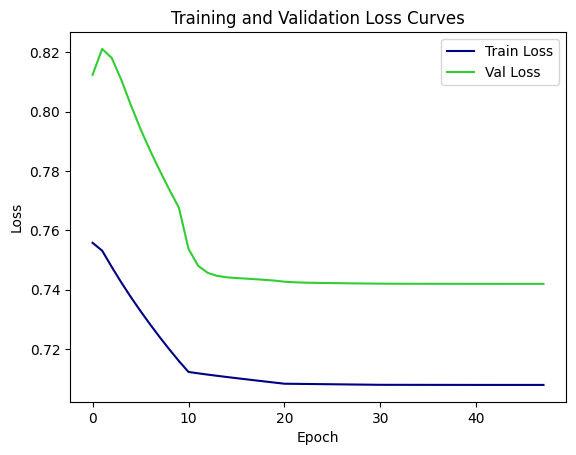

In [ ]:
# Plot the training and validation loss curves with labeled colors

plt.plot(train_losses_3, label='Train Loss', color='navy')
plt.plot(valid_losses_3, label='Val Loss', color='limegreen')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

## Let's evaluate the model on the test dataset.

In [ ]:
test_acc_3= test_accuracy(model_3)
print("Test accuracy =", round(test_acc_3,2))

Test accuracy = 53.98


### Let's load the saved best model and test it in our test_data set

In [20]:
#Load the best_model 

state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/Mini_network/best_model.pt')
model = MiniNetversion_DenseASPP(3)
model.load_state_dict(state_dict)




<All keys matched successfully>

In [22]:
test_acc= test_accuracy(model)
print("Test accuracy =", round(test_acc,2))

Test accuracy = 53.98
